In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import librosa
import librosa.display
import scipy.constants as const
import scipy
import IPython.display
from scipy.io import wavfile
from IPython.core.display import HTML
from __future__ import division
from tensorflow.python.platform import gfile
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
from tensorflow.python.tools import freeze_graph
import matplotlib.pyplot as plt

In [3]:
PATH_TEST = "./dataset/test"
PATH_TRAINING = "./dataset/train"
n_mfcc = 20
mfcc_start = 3
mfcc_end = 17
mfcc_stored = mfcc_end - mfcc_start
n_samples = 6

def load_vowel(folder, size=4):
    wav_files = os.listdir(folder)[0:size]
    dataset = np.ndarray(shape=(len(wav_files), mfcc_stored, n_samples), dtype=np.float32)
    num_files = 0
    for wav_file in wav_files:
        wave, sr = librosa.load(os.path.join(folder, wav_file), mono=True, offset=0.5, duration=0.125)
        mfccs = librosa.feature.mfcc(y=wave, sr=sr, n_mfcc=n_mfcc)
        dataset[num_files,:,:] = mfccs[mfcc_start:mfcc_end, :] / 100
        num_files += 1
    return dataset


In [4]:
def load_datasets(folder, size):
    vowels = os.listdir(folder)
    label = 0
    vowels_amount = len(vowels)
    datasets = np.ndarray(shape=(vowels_amount * size, mfcc_stored, n_samples), dtype=np.float32)
    labels = np.ndarray(shape=(vowels_amount * size), dtype=np.int)
    ind_start, ind_end = 0, size
    for vowel in vowels:
        vowel_folder = os.path.join(folder, vowel)
        vowel_dataset = load_vowel(vowel_folder, size)
        datasets[ind_start:ind_end,:,:] = vowel_dataset
        labels[ind_start:ind_end] = label
        ind_start += size
        ind_end += size
        label += 1
    print("Datasets Shape:", datasets.shape, labels.shape)
    return datasets, labels

datasets, labels = load_datasets(PATH_TRAINING, 4)

#Randomize dataset
np.random.seed(133)
permutation = np.random.permutation(labels.shape[0])
datasets = datasets[permutation,:,:]
labels = labels[permutation]

#save dataset
pickle_file = os.path.join("./", 'vowels.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': datasets,
    'train_labels': labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise



Datasets Shape: (28, 14, 6) (28,)


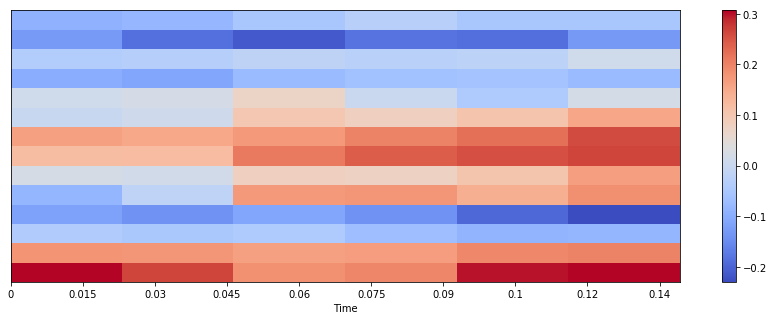

In [5]:
mfccs = datasets[4,:,:]
plt.figure(figsize=(15,5))
plt.title = "MFCC"
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()

In [6]:
num_labels = 7

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, mfcc_stored * n_samples)).astype(np.float32)
  # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels

train_dataset, train_labels = reformat(datasets, labels)
print('Training set', train_dataset.shape, train_labels.shape)

Training set (28, 84) (28, 7)


In [7]:

graph = tf.Graph()
with graph.as_default():

  # Input data.
  # Load the training, validation and test data into constants that are
  # attached to the graph.
  tf_train_dataset = tf.placeholder(tf.float32,shape=(num_labels * 4, mfcc_stored * n_samples), name="input")
  tf_train_labels = tf.placeholder(tf.float32, shape=(num_labels * 4, num_labels), name="label")
  
  weights = tf.Variable(
    tf.truncated_normal([mfcc_stored * n_samples, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))

  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  train_prediction = tf.nn.softmax(logits, name="prediction")

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [8]:
num_steps = 2001

def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  feed_dict = {tf_train_dataset : train_dataset, tf_train_labels : train_labels}
  for step in range(num_steps):
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 100 == 0):
      print('Loss at step %d: %f' % (step, l))
      print('Training accuracy: %.1f%%' % accuracy(predictions, train_labels))
  saver = tf.train.Saver()
  last_checkpoint = './model.cptk'
  saver.save(session, last_checkpoint)
  tf.train.write_graph(session.graph_def, "./", 'raw_graph_def.pb', as_text=False)
  print("Saved checkpoint")

Initialized
Loss at step 0: 2.533169
Training accuracy: 14.3%
Loss at step 100: 1.352413
Training accuracy: 50.0%
Loss at step 200: 0.893382
Training accuracy: 71.4%
Loss at step 300: 0.646294
Training accuracy: 96.4%
Loss at step 400: 0.497023
Training accuracy: 96.4%
Loss at step 500: 0.399033
Training accuracy: 96.4%
Loss at step 600: 0.330812
Training accuracy: 100.0%
Loss at step 700: 0.281129
Training accuracy: 100.0%
Loss at step 800: 0.243624
Training accuracy: 100.0%
Loss at step 900: 0.214466
Training accuracy: 100.0%
Loss at step 1000: 0.191239
Training accuracy: 100.0%
Loss at step 1100: 0.172355
Training accuracy: 100.0%
Loss at step 1200: 0.156733
Training accuracy: 100.0%
Loss at step 1300: 0.143617
Training accuracy: 100.0%
Loss at step 1400: 0.132461
Training accuracy: 100.0%
Loss at step 1500: 0.122867
Training accuracy: 100.0%
Loss at step 1600: 0.114535
Training accuracy: 100.0%
Loss at step 1700: 0.107235
Training accuracy: 100.0%
Loss at step 1800: 0.100790
Traini

In [9]:

freeze_graph.freeze_graph(input_graph = './raw_graph_def.pb',
              input_binary = True,
              input_checkpoint = last_checkpoint,
              output_node_names = "prediction",
              output_graph = './model.bytes' ,
              clear_devices = True, initializer_nodes = "",input_saver = "",
              restore_op_name = "save/restore_all", filename_tensor_name = "save/Const:0")

INFO:tensorflow:Restoring parameters from ./model.cptk
INFO:tensorflow:Froze 2 variables.
Converted 2 variables to const ops.
